In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from DataGenerator2D import DataGenerator2D
from Models import Resunet
from Evaluation_matrices import iou, f1, dice_coef, dice_coef_loss
from Federated import scale_model_weights, sum_scaled_weights

In [2]:
#initialize global model
Resunet = Resunet()
global_model = Resunet.build_model()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D('//PATH TO FIRST CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D('//PATH TO SECOND CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D('//PATH TO THIRD CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 16  64         ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 batch_normalization_37 (BatchN  (None, 32, 32, 128)  512        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_41 (Conv2D)             (None, 32, 32, 128)  73856       ['add_11[0][0]']                 
                                                                                                  
 activation_25 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 32, 32, 128)  512        ['conv2d_41[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_47 (BatchN  (None, 64, 64, 320)  1280       ['concatenate_5[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 activation_32 (Activation)     (None, 64, 64, 320)  0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 128)  368768      ['activation_32[0][0]']          
                                                                                                  
 batch_normalization_48 (BatchN  (None, 64, 64, 128)  512        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
          

 conv2d_57 (Conv2D)             (None, 256, 256, 32  9248        ['activation_37[0][0]']          
                                )                                                                 
                                                                                                  
 add_17 (Add)                   (None, 256, 256, 32  0           ['batch_normalization_55[0][0]', 
                                )                                 'conv2d_57[0][0]']              
                                                                                                  
 conv2d_59 (Conv2D)             (None, 256, 256, 1)  33          ['add_17[0][0]']                 
                                                                                                  
Total params: 6,287,729
Trainable params: 6,280,433
Non-trainable params: 7,296
__________________________________________________________________________________________________


In [3]:
lr = 1e-3
counter = 0
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = Resunet.build_model() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ")
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights('//PATH TO SAVE YOUR FEDERATED WEIGHTS//')
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print(r"Model Saved in //PATH TO SAVE YOUR FEDERATED WEIGHTS//")
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
        
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 17s 498ms/step - loss: 0.6442 - f1: 0.3651 - iou: 0.2259 - dice_coef: 0.3558
Performance Matrix 
11/11 [==============================] - 11s 775ms/step - loss: 0.8961 - f1: 0.1032 - iou: 0.0546 - dice_coef: 0.1032
Model loss imporved from inf to 0.8961393237113953
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 16s 451ms/step - loss: 0.4471 - f1: 0.5637 - iou: 0.4056 - dice_coef: 0.5529
Performance Matrix 
11/11 [=======

30/30 [==============================] - 10s 262ms/step - loss: 0.0809 - f1: 0.9232 - iou: 0.8809 - dice_coef: 0.9191
Performance Matrix 
11/11 [==============================] - 8s 621ms/step - loss: 0.0979 - f1: 0.8949 - iou: 0.8460 - dice_coef: 0.8974
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  19
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 259ms/step - loss: 0.0633 - f1: 0.9374 - iou: 0.9116 - dice_coef: 0.9367
Performance Matrix 
11/11 [==============================] - 8s 613ms/step - loss: 0.0777 - f1: 0.9142 - iou: 0.8741 - dice_coef: 0.9167
Model loss imporved from 0.09272626787424088 to 0.07768087834119797
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetGlobalWeights.h5
-----------------------------------------------------------------

30/30 [==============================] - 10s 262ms/step - loss: 0.0157 - f1: 0.9843 - iou: 1.0020 - dice_coef: 0.9843
Performance Matrix 
11/11 [==============================] - 8s 613ms/step - loss: 0.0344 - f1: 0.9601 - iou: 0.9599 - dice_coef: 0.9625
Model loss imporved from 0.04223102703690529 to 0.034405309706926346
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  38
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 261ms/step - loss: 0.0056 - f1: 0.9945 - iou: 1.0149 - dice_coef: 0.9944
Performance Matrix 
11/11 [==============================] - 8s 611ms/step - loss: 0.0440 - f1: 0.9515 - iou: 0.9405 - dice_coef: 0.9536
----------------------------------------------------------------

30/30 [==============================] - 10s 258ms/step - loss: -0.0562 - f1: 1.0562 - iou: 1.1501 - dice_coef: 1.0562
Performance Matrix 
11/11 [==============================] - 7s 613ms/step - loss: 0.0321 - f1: 0.9630 - iou: 0.9708 - dice_coef: 0.9659
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  58
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 252ms/step - loss: -0.0567 - f1: 1.0611 - iou: 1.1646 - dice_coef: 1.0607
Performance Matrix 
11/11 [==============================] - 7s 606ms/step - loss: 0.0300 - f1: 0.9660 - iou: 0.9741 - dice_coef: 0.9682
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  59
----------------------------

30/30 [==============================] - 10s 254ms/step - loss: -0.0649 - f1: 1.0648 - iou: 1.1715 - dice_coef: 1.0649
Performance Matrix 
11/11 [==============================] - 7s 597ms/step - loss: 0.0308 - f1: 0.9656 - iou: 0.9771 - dice_coef: 0.9682
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  69
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 249ms/step - loss: -0.0794 - f1: 1.0831 - iou: 1.2167 - dice_coef: 1.0835
Performance Matrix 
11/11 [==============================] - 7s 597ms/step - loss: 0.0301 - f1: 0.9660 - iou: 0.9777 - dice_coef: 0.9685
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  70
----------------------------

30/30 [==============================] - 10s 268ms/step - loss: -0.0854 - f1: 1.0851 - iou: 1.2181 - dice_coef: 1.0854
Performance Matrix 
11/11 [==============================] - 8s 621ms/step - loss: 0.0300 - f1: 0.9660 - iou: 0.9770 - dice_coef: 0.9683
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  90
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 272ms/step - loss: -0.0858 - f1: 1.0852 - iou: 1.2242 - dice_coef: 1.0858
Performance Matrix 
11/11 [==============================] - 8s 608ms/step - loss: 0.0298 - f1: 0.9662 - iou: 0.9775 - dice_coef: 0.9685
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  91
----------------------------

11/11 [==============================] - 8s 616ms/step - loss: 0.0302 - f1: 0.9659 - iou: 0.9769 - dice_coef: 0.9682
---------------------------------------------------------------------------------------


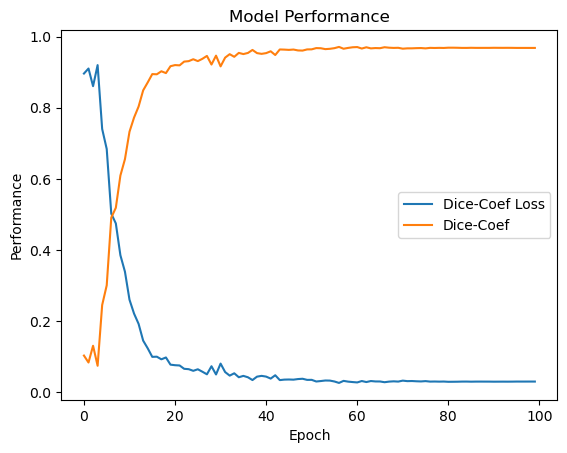

In [4]:
performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

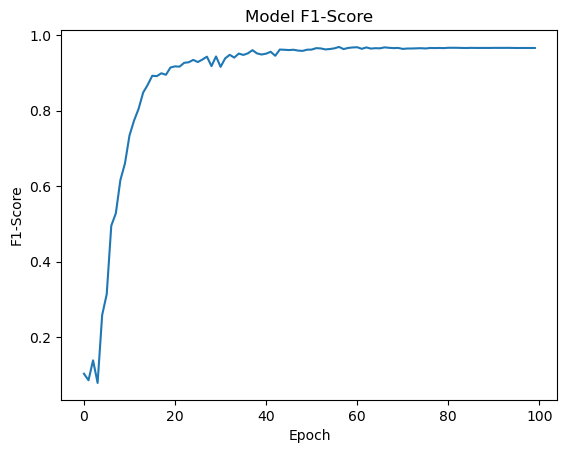

In [5]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

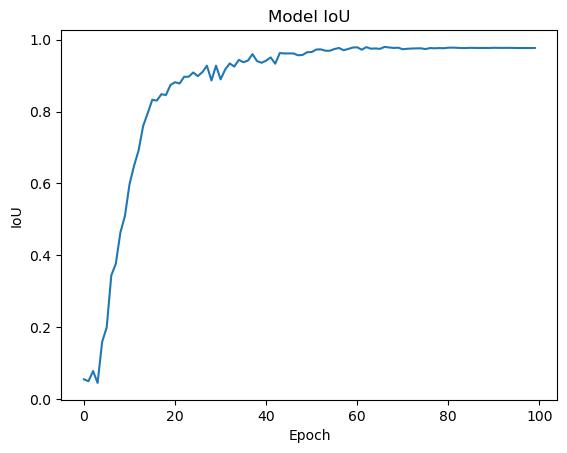

In [6]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [7]:
val_generator = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256,batch_size=128, shuffle=True)
global_model = Resunet.build_model()
global_model.load_weights('//PATH TO YOUR FEDERATED RESUNET MODEL WEIGHTS.h5//')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)

3/3 [==============================] - 24s 7s/step - loss: 0.0263 - f1: 0.9695 - iou: 0.9781 - dice_coef: 0.9719


In [8]:
X, y = val_generator.__getitem__(0)
predict = global_model.predict(X)

4/4 [==============================] - 2s 189ms/step


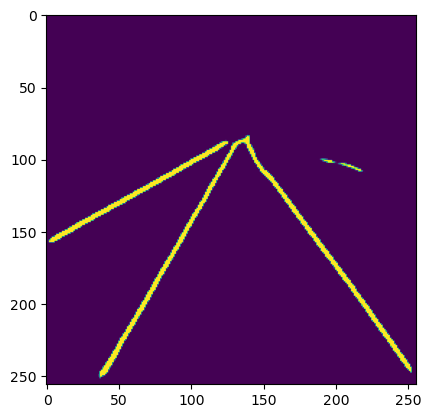

In [9]:
img = predict[2]
plt.imshow(img)

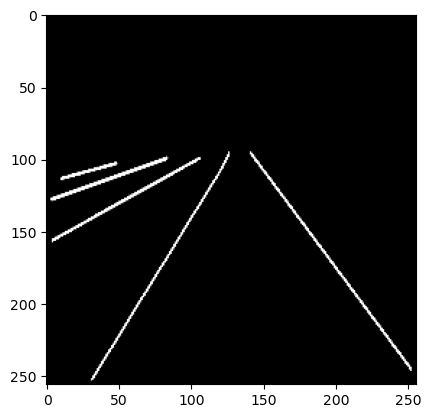

In [10]:
img1 = y[2]
plt.imshow(img1)

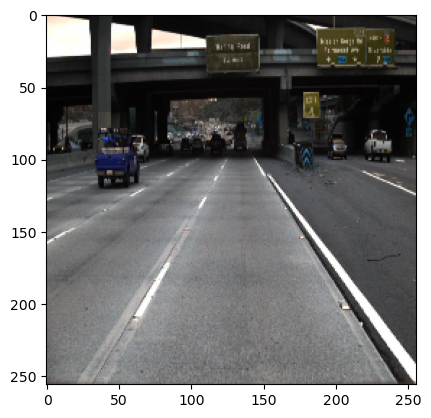

In [13]:
img2 = X[2]
plt.imshow(img2)